# **Imports**

In [1]:
# data handle
from tensorflow.keras.layers import Dense, BatchNormalization, InputLayer, ReLU

import tensorflow as tf
import pandas as pd
import numpy as np

# metrics
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

# graphs
import matplotlib.pyplot as plt

# system
from IPython.display import clear_output

import tqdm
import os

%matplotlib inline

In [2]:
# setting up environment configs
devices = tf.config.list_physical_devices()
if devices.__len__():
    try:
        device = devices[0]
        # looking for gpu
        for dev in devices:
            if dev.device_type == 'XLA_GPU':
                device = dev
                break
            elif dev.device_type == 'GPU':
                device = dev
        tf.config.set_visible_devices(devices=device, device_type=device.device_type)
        device = tf.config.list_logical_devices(device_type=device.device_type)[0]
    except Exception as e:
        print(e)
    else:
        print(f'GPU has been selected: {device}')

GPU has been selected: LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU')


# **Training**

### **Training parameters**

In [3]:
EPOCH = 100
BATCH = 8

LEARNING_RATE = 1e-5

EARLY_STOP = 5

LOSS_FUNC = MeanSquaredError()
OPT = Adam(learning_rate=LEARNING_RATE)

In [4]:
# loss graph
def loss_graph(loss, val_loss, save_info=None):
    
    clear_output()
    
    # figure configs
    plt.figure(figsize=(8,4))
    ax = plt.gca()
    ax.set_facecolor((0.9, 0.9, 0.9))
    
    # main plot
    plt.plot(loss, color='blue', linewidth=2)
    plt.plot(val_loss, color='green', linewidth=2)
    
    # axis configs
    plt.title('Training loss along iterations', fontsize=12)
    plt.xlabel(
        'Iterations',
        color='gray',
        loc='left'
    )
    plt.ylabel(
        'Current\nLoss',
        ha='left',
        position=(-.1, .85),
        labelpad=70,
        rotation=0,
        fontsize=16,
        color='gray'
    )
    
    # extra info
    plt.legend(
        labels=[f'Train: {loss[-1]}', f'Val: {val_loss[-1]}'],
        loc='upper center'
    )
    if not save_info is None:
        plt.suptitle(f'Model has been saved at epoch: {save_info}', fontsize=8)
    
    plt.show()

    
    

def loss_graph(loss, val_loss, save_info=None):
    
    clear_output()
    
    # figure configs
    fig = plt.figure(figsize=(8,4))
    
    # main plot
    ax_train = fig.add_subplot(111)
    ax_val = fig.add_subplot(111, frame_on=False)
    
    ax_train.plot(loss, color='blue', linewidth=2)
    ax_val.plot(val_loss, color='orange', linewidth=2)
    
    # axis configs
    ax_train.set_title('Training loss along iterations', fontsize=12)
    ax_train.set_xlabel(
        'Iterations',
        color='gray',
        loc='left'
    )
    ax_train.set_ylabel(
        'Current\nLoss',
        ha='left',
        position=(-.1, .85),
        labelpad=70,
        rotation=0,
        fontsize=16,
        color='gray'
    )
    ax_val.set_xticks([])
    ax_val.set_yticks([])
    
    # extra info
    if not save_info is None:
        plt.suptitle(f'Model has been saved at epoch: {save_info}', fontsize=8)
    
    plt.show()

### **Preparing dataset**

In [5]:
# loading dataset
df = pd.read_csv('../datasets/avg_temp_in_brazil.csv')

# dropping 'Unnamed: 0' column if exits
if 'Unnamed: 0' in df.columns:
    df.drop(labels='Unnamed: 0', axis=1, inplace=True)
    
# converting dataset to tf tensor
df = tf.convert_to_tensor(df)

In [6]:
# transforming dataset to a dataset
# for time series (my case problem)
df_time_series = []

for index in range(df.shape[0]-12):
    df_time_series.append(df[index:13+index,2])

df_time_series = tf.stack(df_time_series)

### **Splitting data**

In [7]:
train_size = int(df_time_series.shape[0] * 0.7)
val_size = int((df_time_series.shape[0] - train_size) / 3)
test_size = int(df_time_series.shape[0] - train_size - val_size)

print(train_size)
print(test_size)
print(val_size)

# checking if the sum of all sizes
# correspond to the entire dataset
print(f'''
Dataset rows: {df_time_series.shape[0]}\n
Sum of split: {train_size + test_size + val_size}
''')

1361
390
194

Dataset rows: 1945

Sum of split: 1945



In [8]:
# generating dataset for train
# test and val
train = df_time_series[:train_size,:]
val = df_time_series[train_size:train_size+val_size,:]
test = df_time_series[train_size+val_size:,:]

# splitting into x and y
x_train = train[:,:12]
y_train = train[:,12]
x_test = test[:,:12]
y_test = test[:,12]
x_val = val[:,:12]
y_val = val[:,12]

# converting to tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH)

### **Building model**

In [9]:
def conv_layer(x, neurons:int):
    x = Dense(units=neurons)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

class ClimateModel(tf.keras.Model):
    
    def __init__(self):
        super(ClimateModel, self).__init__()
        
        self.inputs = InputLayer(input_shape=(1,12))
        self.outputs = Dense(units=1)
    
        self.dense_1 = Dense(units=512)
        self.norm_1 = BatchNormalization()
        self.relu_1 = ReLU()
        
        self.dense_2 = Dense(units=256)
        self.norm_2 = BatchNormalization()
        self.relu_2 = ReLU()
        
        self.dense_3 = Dense(units=128)
        self.norm_3 = BatchNormalization()
        self.relu_3 = ReLU()
        
        self.dense_4 = Dense(units=64)
        self.norm_4 = BatchNormalization()
        self.relu_4 = ReLU()
    
    def call(self, x):
        
        x = self.inputs(x)
        
        x = self.dense_1(x)
        x = self.norm_1(x)
        x = self.relu_1(x)
        
        x = self.dense_2(x)
        x = self.norm_2(x)
        x = self.relu_2(x)
        
        x = self.dense_3(x)
        x = self.norm_3(x)
        x = self.relu_3(x)
        
        x = self.dense_4(x)
        x = self.norm_4(x)
        x = self.relu_4(x)
        
        x = self.outputs(x)
        
        return x

##### **Testing model architecture**

In [10]:
model = ClimateModel()
_ = model(tf.zeros(shape=[1,12]))

In [11]:
model.summary()

Model: "climate_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 12)]           0         
_________________________________________________________________
dense (Dense)                multiple                  65        
_________________________________________________________________
dense_1 (Dense)              multiple                  6656      
_________________________________________________________________
batch_normalization (BatchNo multiple                  2048      
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  131328    
_________________________________________________________________
batch_normalization_1 (Batch multiple                

### **Training model**

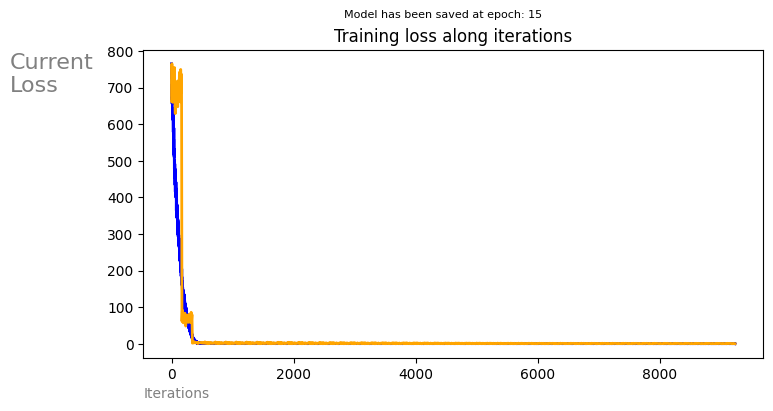

EPOCHS: 55/100: 100%|████████████████████████████████████████████████████████████████| 171/171 [00:02<00:00, 83.78it/s]


[Early Stop] - Model has been started overfitting.


In [12]:
# custom training loop
TRAIN_LOSS = []
VAL_LOSS = []

LAST_LOSS_VAL = None
counter = 0

weights_path = os.path.join('..', 'weights', 'climate_weights_model')

BEST_LOSS = {
    'train':None,
    'val':None
}

saved = None

for epochs in range(EPOCH):

    # with tf.device(device.name):
    # training
    for (x_train_batch, y_train_batch) in tqdm.tqdm(iterable=train_dataset, desc=f'EPOCHS: {epochs+1}/{EPOCH}'):

        # gradiant
        with tf.GradientTape() as tape:

            pred = model(x_train_batch)
            train_loss = LOSS_FUNC(y_train_batch, pred)

        grads = tape.gradient(train_loss, model.trainable_weights)
        OPT.apply_gradients(zip(grads, model.trainable_weights))

        # saving losses
        TRAIN_LOSS.append(train_loss)

    # validation:
    for (x_val_batch, y_val_batch) in val_dataset:

        pred = model(x_val_batch, training=False)
        val_loss = LOSS_FUNC(y_val_batch, pred)

        # saving losses
        VAL_LOSS.append(val_loss)

    # saving best model
    if BEST_LOSS['train'] is None:
        BEST_LOSS['train'] = train_loss
        BEST_LOSS['val'] = val_loss
        model.save(weights_path)
        saved = epochs + 1
    else:
        if BEST_LOSS['train'] > train_loss and BEST_LOSS['val'] > val_loss:
            BEST_LOSS['train'] = train_loss
            BEST_LOSS['val'] = val_loss
            model.save(weights_path)
            saved = epochs + 1
            
    # checking if it is overfitting
    if not LAST_LOSS_VAL is None:
        if val_loss >= LAST_LOSS_VAL:
            counter += 1
        else:
            if counter > 0:
                counter -= 1
    LAST_LOSS_VAL = val_loss
    
    if counter == EARLY_STOP:
        print('[Early Stop] - Model has been started overfitting.')
        break

    # displaying losses
    loss_graph(TRAIN_LOSS, VAL_LOSS, saved)

# **Testing**

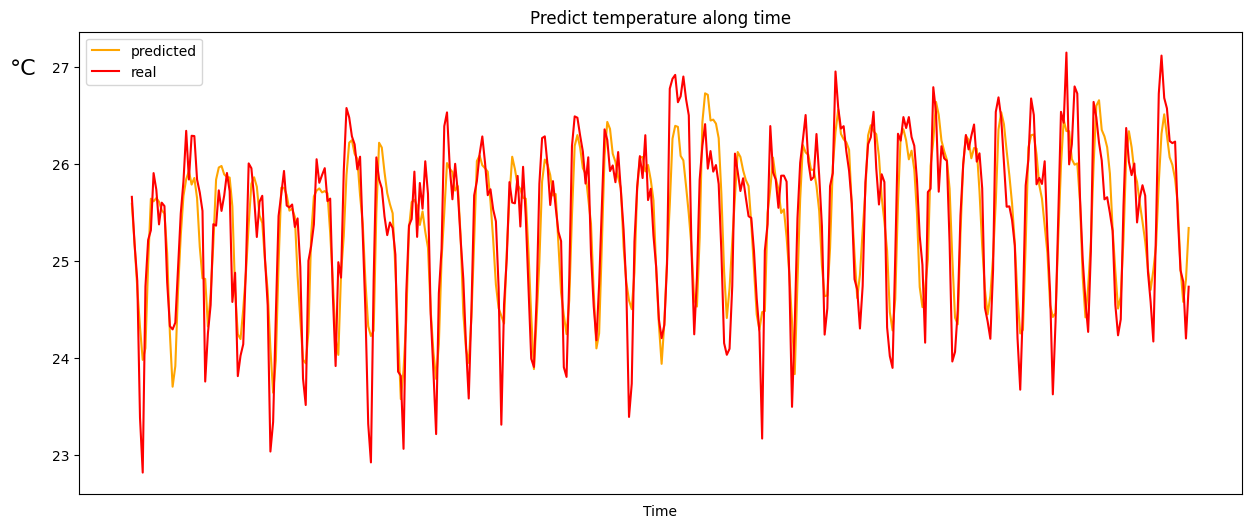

In [13]:
pred = model.predict(x_test)
# time_for_test = df[train_size+val_size:,:][12:][:,0]

plt.figure(figsize=(15,6))

plt.plot(pred, label='predicted', color='orange')
plt.plot(y_test, label='real', color='red')

plt.legend()
plt.title('Predict temperature along time', fontsize=12)
plt.ylabel(
    '°C',
    fontsize=16,
    rotation=0,
    position=(-.1, .9),
    ha='left',
    labelpad=30
)
plt.xlabel('Time')

plt.xticks([])

plt.show()